### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
!unzip -q /content/gdrive/My\ Drive/CNN_Assignment/CNN_assignment

In [4]:
!ls

 gdrive   sample_data  'Skin cancer ISIC The International Skin Imaging Collaboration'


In [5]:
!ls "Skin cancer ISIC The International Skin Imaging Collaboration"

Test  Train


In [6]:
# Defining the path for train and test images
# Update the paths of the train and test dataset
data_train_dir = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_test_dir = pathlib.Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [8]:
# Printing the count of images in each directory
img_count_train = len(list(data_train_dir.glob('*/*.jpg')))
print("Train images:\t", img_count_train)
img_count_test = len(list(data_test_dir.glob('*/*.jpg')))
print("Test images:\t", img_count_test)

Train images:	 2239
Test images:	 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Defining the image dimensions and the batch size


Using 80-20 split for Train-Validation split below

In [10]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [11]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# The folder structure is such that the directory names correspond to the classes of skin cancer.
# Each directory has the image files for the respective class of skin cancer.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
- Code snippet to visualize one instance of all the nine classes present in the dataset

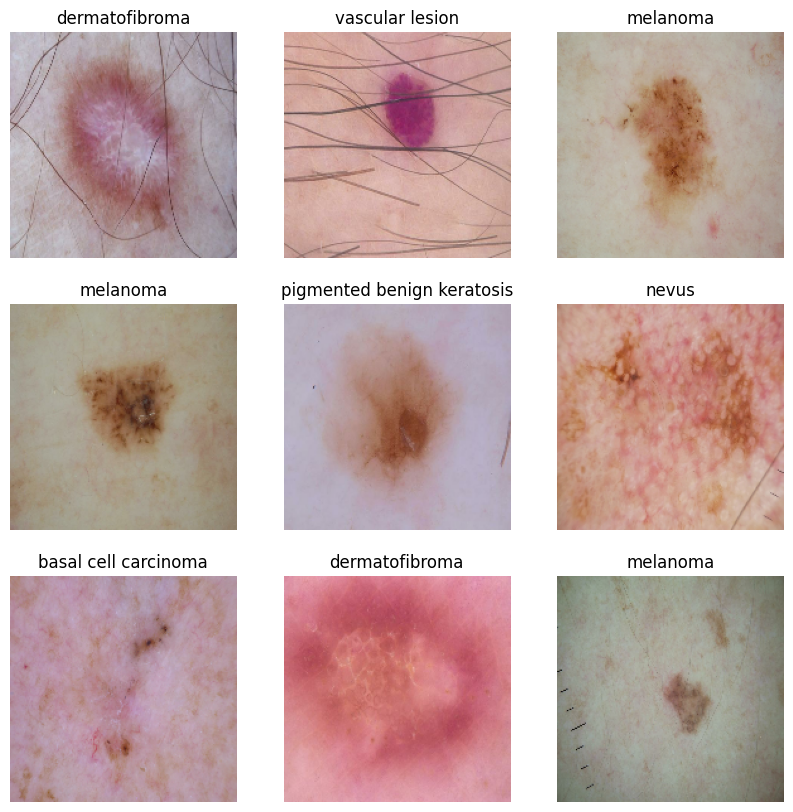

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

In [15]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# Displays the summary of all the layers involved
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [18]:
epochs = 20
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 33s 53ms/step - loss: 1.9057 - accuracy: 0.2830 - val_loss: 1.5522 - val_accuracy: 0.4053
Epoch 2/20
169/169 [==============================] - 4s 21ms/step - loss: 1.3457 - accuracy: 0.4963 - val_loss: 1.2005 - val_accuracy: 0.5568
Epoch 3/20
169/169 [==============================] - 4s 22ms/step - loss: 1.1016 - accuracy: 0.6014 - val_loss: 1.1462 - val_accuracy: 0.5954
Epoch 4/20
169/169 [==============================] - 4s 22ms/step - loss: 0.8992 - accuracy: 0.6805 - val_loss: 1.0739 - val_accuracy: 0.6273
Epoch 5/20
169/169 [==============================] - 3s 21ms/step - loss: 0.6798 - accuracy: 0.7645 - val_loss: 0.9024 - val_accuracy: 0.7016
Epoch 6/20
169/169 [==============================] - 3s 20ms/step - loss: 0.4998 - accuracy: 0.8181 - val_loss: 0.8509 - val_accuracy: 0.7275
Epoch 7/20
169/169 [==============================] - 4s 23ms/step - loss: 0.4299 - accuracy: 0.8526 - val_loss: 0.8081 - val_accuracy: 0.746

### Visualizing training results

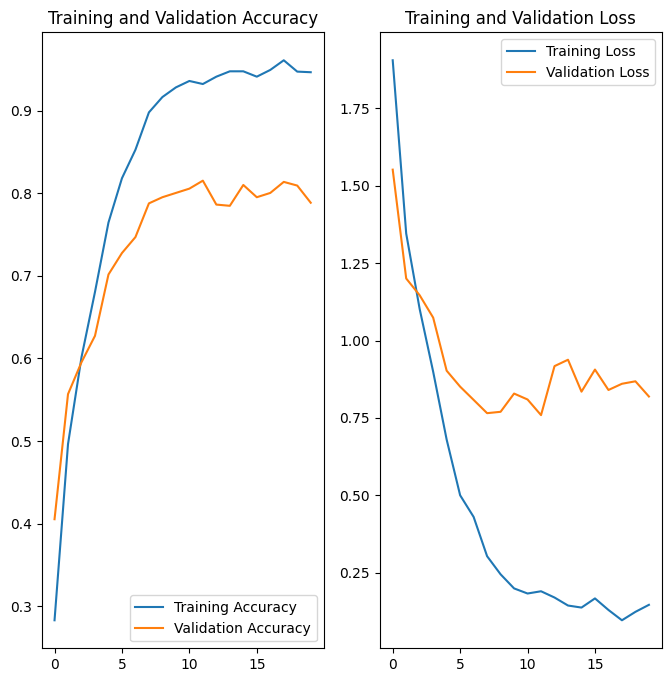

In [19]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable — a sign of overfitting.

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

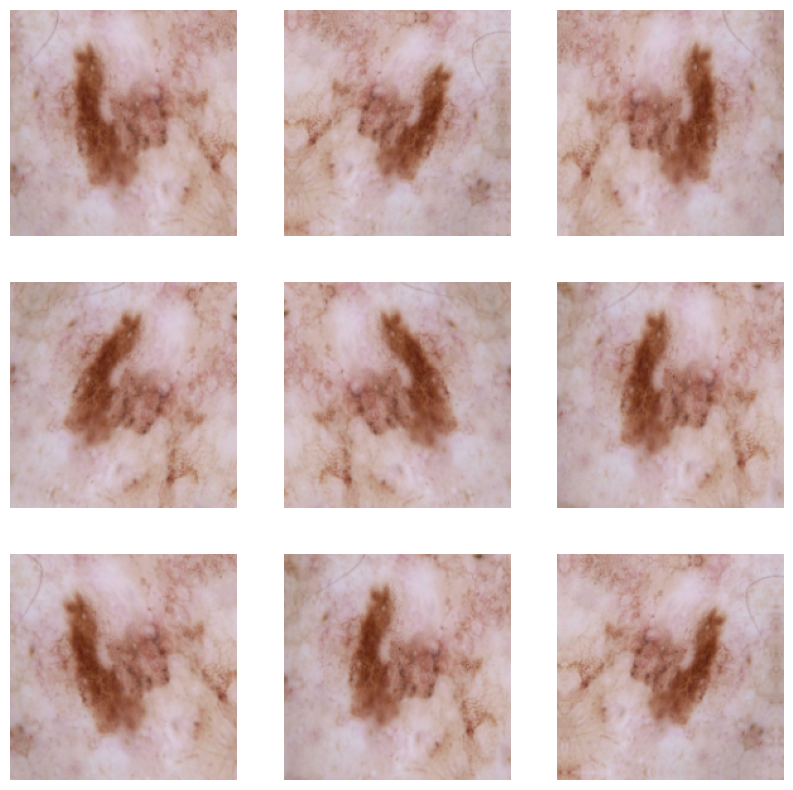

In [21]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Create the model, compile and train the model


In [22]:
## Using Dropout layer since there is an evidence of overfitting in the findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [23]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [24]:
epochs = 20
hist = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 8s 30ms/step - loss: 1.9811 - accuracy: 0.2480 - val_loss: 1.6239 - val_accuracy: 0.3905
Epoch 2/20
169/169 [==============================] - 5s 31ms/step - loss: 1.5404 - accuracy: 0.4175 - val_loss: 1.4396 - val_accuracy: 0.4766
Epoch 3/20
169/169 [==============================] - 5s 29ms/step - loss: 1.3876 - accuracy: 0.4740 - val_loss: 1.3396 - val_accuracy: 0.4707
Epoch 4/20
169/169 [==============================] - 5s 29ms/step - loss: 1.3201 - accuracy: 0.5032 - val_loss: 1.3698 - val_accuracy: 0.4892
Epoch 5/20
169/169 [==============================] - 5s 32ms/step - loss: 1.2797 - accuracy: 0.5184 - val_loss: 1.1851 - val_accuracy: 0.5620
Epoch 6/20
169/169 [==============================] - 5s 30ms/step - loss: 1.1890 - accuracy: 0.5495 - val_loss: 1.1665 - val_accuracy: 0.5635
Epoch 7/20
169/169 [==============================] - 5s 30ms/step - loss: 1.1176 - accuracy: 0.5759 - val_loss: 1.0920 - val_accuracy: 0.5887

### Visualizing the results

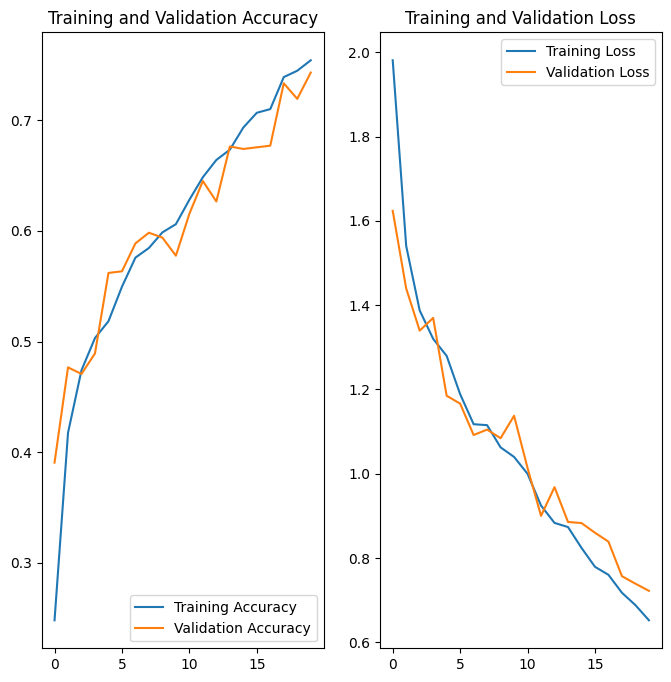

In [25]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_train_dir, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_train_dir, '*', '*.jpg'))]
len(path_list)

2239

In [27]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
1,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
2,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
3,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
4,Skin cancer ISIC The International Skin Imagin...,actinic keratosis
...,...,...
2234,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2235,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2236,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma
2237,Skin cancer ISIC The International Skin Imagin...,basal cell carcinoma


Class=0, n=114 (5.092%)
Class=2, n=95 (4.243%)
Class=6, n=77 (3.439%)
Class=8, n=139 (6.208%)
Class=4, n=357 (15.945%)
Class=3, n=438 (19.562%)
Class=5, n=462 (20.634%)
Class=7, n=181 (8.084%)
Class=1, n=376 (16.793%)


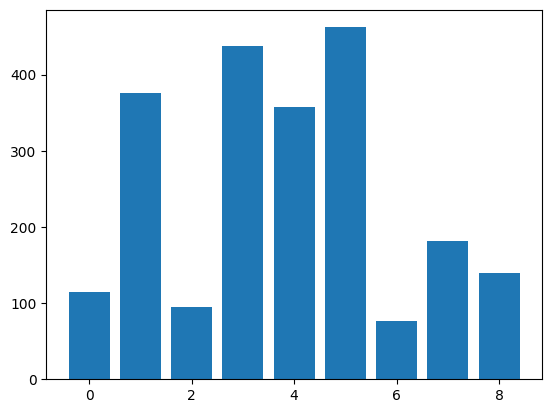

In [28]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

##Write your findings here:
#### - Which class has the least number of samples?
- Class 6 has the least number of sample (n=77)

<br>

#### - Which classes dominate the data in terms proportionate number of samples?
- Class 5 has the highest percentage of samples at 20.634%


# Rectifying the class imbalance
#### Using the python package 'Augmentor'

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8B283CC2B0>: 100%|██████████| 500/500 [00:19<00:00, 25.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8B2830F880>: 100%|██████████| 500/500 [00:20<00:00, 24.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8BDC42A5F0>: 100%|██████████| 500/500 [00:21<00:00, 22.77 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=964x640 at 0x7E8B283523E0>: 100%|██████████| 500/500 [01:29<00:00,  5.58 Samples/s]


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8B2838E6B0>: 100%|██████████| 500/500 [01:17<00:00,  6.44 Samples/s]


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8BDCF70D60>: 100%|██████████| 500/500 [00:16<00:00, 30.04 Samples/s]


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8B28350BE0>: 100%|██████████| 500/500 [00:37<00:00, 13.37 Samples/s]


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8B283CE0E0>: 100%|██████████| 500/500 [00:16<00:00, 30.38 Samples/s]


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8B28351330>: 100%|██████████| 500/500 [00:16<00:00, 30.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [31]:
img_count_train = len(list(data_train_dir.glob('*/output/*.jpg')))
print(img_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list_new = [x for x in glob(os.path.join(data_train_dir, '*','output', '*.jpg'))]

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_train_dir, '*','output', '*.jpg'))]

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [35]:
df_2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
class_balanced_df = original_df.append(df_2)

<ipython-input-35-dc9579ea82bf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_balanced_df = original_df.append(df_2)


In [36]:
class_balanced_df['Label'].value_counts()

pigmented benign keratosis    1462
melanoma                      1438
basal cell carcinoma          1376
nevus                         1357
squamous cell carcinoma       1181
vascular lesion               1139
actinic keratosis             1114
dermatofibroma                1095
seborrheic keratosis          1077
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

## Training the Model

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Using 8992 files for training.


In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_train_dir,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


## Creating a model including normalization

In [40]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [41]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [42]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
281/281 [==============================] - 49s 61ms/step - loss: 1.7544 - accuracy: 0.3292 - val_loss: 1.4290 - val_accuracy: 0.4495
Epoch 2/30
281/281 [==============================] - 8s 29ms/step - loss: 1.2870 - accuracy: 0.5258 - val_loss: 1.1270 - val_accuracy: 0.5915
Epoch 3/30
281/281 [==============================] - 8s 30ms/step - loss: 0.9876 - accuracy: 0.6441 - val_loss: 0.9195 - val_accuracy: 0.6667
Epoch 4/30
281/281 [==============================] - 8s 29ms/step - loss: 0.7635 - accuracy: 0.7271 - val_loss: 0.7424 - val_accuracy: 0.7312
Epoch 5/30
281/281 [==============================] - 8s 29ms/step - loss: 0.5526 - accuracy: 0.8066 - val_loss: 0.6285 - val_accuracy: 0.7815
Epoch 6/30
281/281 [==============================] - 8s 29ms/step - loss: 0.4483 - accuracy: 0.8430 - val_loss: 0.5988 - val_accuracy: 0.8020
Epoch 7/30
281/281 [==============================] - 8s 29ms/step - loss: 0.3380 - accuracy: 0.8816 - val_loss: 0.5661 - val_accuracy: 0.803

## Visualizing the model results

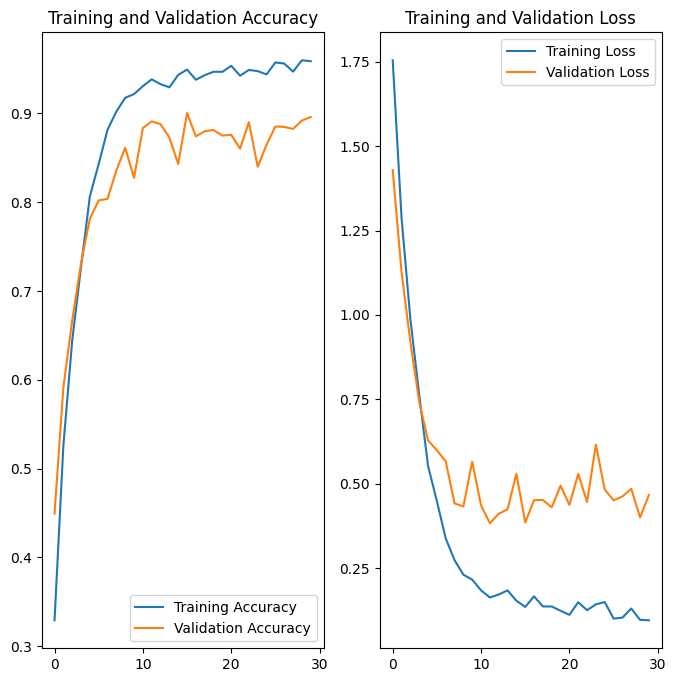

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
- Class rebalancing has help in the reduction of overfitting.
- As you can see in the difference of the first graph and the graph above, the Validation Accuracy has increased and when compared to the Training Accuracy.
- You can see that the recent model performs better on the unseen Validation dataset.

